In [15]:
# uncomment these lines to install the required dependencies.
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn
# !pip install scikit-learn

In [16]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Übung 5: Perceptron

## Datensatz

Wir benutzen die ``sklearn``-Version des [MNIST data set](https://en.wikipedia.org/wiki/MNIST_database). Es beinhaltet 1797 Graustufen-Bilder (8x8 Pixel) von handgeschriebenen Ziffern.

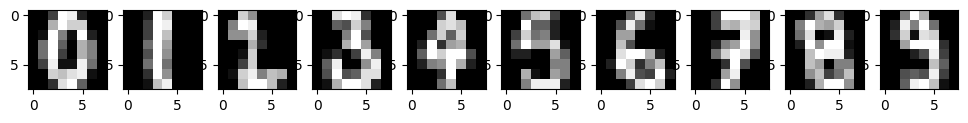

In [17]:
f, ax = plt.subplots(1, 10, figsize=(12, 4))
X, y = load_digits(n_class=10, return_X_y=True)
for i, y_ in enumerate(np.unique(y)):
    ax[i].imshow(X[y==y_][np.random.randint(0, np.sum(y==y_)+1)].reshape(8,8), cmap="gray")

## Aufgabe 1: Two-Class-Perceptron (5 Punkte)

* Vervollständigen Sie die `fit`-Funktion der `TwoClassPerceptron`-Klasse.
* Nutzen Sie für das Training _Stochastic Gradient Descent_.

In [18]:
class TwoClassPerceptron:
    """
    Binary Classifier based on the Perceptron Algorithm using Stochastic Gradient Descent.
    This classifier is constrained to labels of +1 and -1.
    
    Attributes:
        w (numpy.ndarray): weight vector (with extra entry for intercept at index 0)
        history (dict): dictionary with keys `'train'` and `'val'` holding lists of training- and validation
            accuracy per training epoch.
    """
    def __init__(self):
        self.w = None
        self.history = {'train': [], 'val': []}
        
    def _log_iteration(self, X, y, X_val, y_val):
        """
        calculate training and validation accuracy and append to lists in `self.history`
        """
        self.history['train'].append(accuracy_score(y, self.predict(X)))
        if X_val is not None and y_val is not None:
            self.history['val'].append(accuracy_score(y_val, self.predict(X_val)))
    
    @staticmethod
    def _add_intercept_dim(X):
        """
        Prepend a new column with ones to the data matrix for the intercept
        """
        return np.concatenate([np.ones((X.shape[0], 1)), X.copy()], axis=1)
        
    def fit(self, X, y, X_val=None, y_val=None, learning_rate=0.1, max_iterations=100):
        """
        Trains the classifier on `X` and `y` . Logs the training accuracy at each iteration.
        If `X_val` and `y_val` are passed, the validation accuracy at each iteration is logged too.
        
        Args:
            X (numpy.ndarray): 2D training data matrix (columns->features, rows->samples)
            y (numpy.ndarray): 1D training labels vector. 
                -1 for negative class, +1 for positive class
            X_val (numpy.ndarray, optional): 2D validation data matrix (columns->features, rows->samples)
            y_val (numpy.ndarray, optional): 1D validation labels vector.
                -1 for negative class, +1 for positive class
            learning_rate (float, optional): Step size for weight updates per iteration. Defaults to 0.1.
            max_iterations (int, optional): Maximum number of training iterations. Defaults to 100.
        
        Returns:
            None
        """
        X = self._add_intercept_dim(X)
        # initialize weight vector
        self.w = np.random.randn(X.shape[1]) * 1e-5
        for i in range(max_iterations):
            predictions = self.predict(X[:, 1:])
            misclassified = predictions != y
            if not np.any(misclassified):
                break
            misclassified_idx = np.where(misclassified)[0]
            rand_idx = np.random.choice(misclassified_idx, size=None)
            self.w += learning_rate * X[rand_idx] * y[rand_idx] 
            self._log_iteration(X[:, 1:], y, X_val, y_val)
        return None
    
    def predict_proba(self, X):
        """
        Predict a probabilistic measure for the positive class. Returns the projection of X onto
        the weight vector.
        
        Args:
            X (numpy.ndarray): 2D test data matrix (columns->features, rows->samples)
        
        Returns:
            numpy.ndarray: vector of predicted "probalities" (-∞ => 0% prob., 0 => 50% prob, +∞ => 100% prob.)   
        """
        if self.w is None:
            raise ValueError("model is not fitted yet. please call self.fit() first!")
        X = self._add_intercept_dim(X)
        return X @ self.w
    
    def predict(self, X):
        """
        Predict the labels for all data points in `X`.
        
        Args:
            X (numpy.ndarray): 2D test data matrix (columns->features, rows->samples)
        
        Returns:
            numpy.ndarray: vector of predicted labels (-1 or +1)
        """
        return np.sign(self.predict_proba(X))


### Überprüfung

* Im folgenden Code wird ein `TwoClassPerceptron`- Klassifizierer für eine Ziffer trainiert 
* Dazu wird der Datensatz in ein Trainings- und ein Test-Set geteilt
* Zur Visualisierung werden ausgegeben:
    * Klassifizierungsmetriken für das Test-Set
    * Accuracy-Kurven (für jede Trainingsiteration) für das Trainings- und das Test-Set
    * Konfusionsmatrix
    
_Probieren Sie gerne verschiedene Ziffern, Lernraten, Iterationen oder Daten-Splits aus!_

              precision    recall  f1-score   support

       other       1.00      0.99      1.00       412
           5       0.93      1.00      0.96        38

    accuracy                           0.99       450
   macro avg       0.96      1.00      0.98       450
weighted avg       0.99      0.99      0.99       450



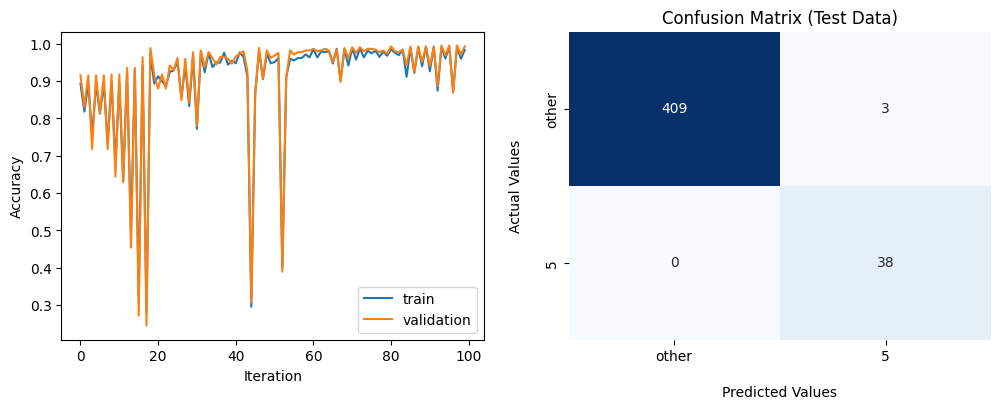

In [19]:
TARGET_DIGIT = 5
LEARNING_RATE = 0.1
MAX_ITERATIONS = 100

# load and split data
X, y = load_digits(n_class=10, return_X_y=True)
# turn labels into -1 and 1
y = np.sign((y==TARGET_DIGIT)* 1.0 - .5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)

# train model and make predictions
perceptron = TwoClassPerceptron()
perceptron.fit(X_train, y_train, X_val=X_test, y_val=y_test, 
               learning_rate=LEARNING_RATE, max_iterations=MAX_ITERATIONS)
predicted = perceptron.predict(X_test)

# plot training and validation accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(perceptron.history['train'])
ax1.plot(perceptron.history['val'])
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Accuracy")
ax1.legend(['train','validation'])

# plot confusion matrix
sns.heatmap(confusion_matrix(y_test, predicted), annot=True, cmap='Blues', fmt=".0f", cbar=False, ax=ax2)
ax2.set_title('Confusion Matrix (Test Data)')
ax2.set_xlabel('\nPredicted Values')
ax2.set_ylabel('Actual Values\n')
ax2.xaxis.set_ticklabels(['other', f'{TARGET_DIGIT}'])
ax2.yaxis.set_ticklabels(['other', f'{TARGET_DIGIT}'])

# print classification metrics
print(classification_report(y_test, predicted, target_names=['other', f'{TARGET_DIGIT}']))

## 2. Zusatzaufgabe: Multi-Class-Perceptron (3 Bonuspunkte)

* Vervollständigen Sie die Klasse `MultiClassPerceptron`, die entsprechend dem [One-vs-Rest-Ansatz](https://en.wikipedia.org/wiki/Multiclass_classification#One-vs.-rest) für mehr als 2 Klassen funktioniert.  
* Nutzen Sie dazu Ihre Implementierung der `TwoClassPerceptron`-Klasse und benutzen Sie die `predict_proba`-Funktion, welche bereits gegeben ist. 
* Beachten Sie, dass die Labels für den `TwoClassPerceptron` $1$ und $-1$ sein müssen.

In [20]:
class MultiClassPerceptron:
    """
    Multi-Class Implementation of a Perceptron Classifier. 
    Trains a binary Perceptron classifier for each label v. rest using Stochastic Gradient Descent. 
    The Predicted Label is the label with the highest probability.
    
    Attributes:
        classifiers (list of TwoClassPerceptron): list of binary Perceptron classifiers (one-vs-rest)
        classes (numpy.ndarray): vector of all classes
    """
    def __init__(self):
        self.classifiers = None
        self.classes = None
        
    def fit(self, X, y, learning_rate=0.1, max_iterations=100):
        self.classes = np.unique(y)
        self.classifiers = []
        for c in self.classes:
            _y = np.sign((y==c)* 1. - .5)
            classifier = TwoClassPerceptron()
            classifier.fit(X, _y, learning_rate=learning_rate, max_iterations=max_iterations)
            self.classifiers.append(classifier)
        
    def predict(self, X):
        predictions = np.empty((X.shape[0], len(self.classes)))
        for col, classifier in enumerate(self.classifiers):
            predictions[:, col] = classifier.predict(X)
        return self.classes[predictions.argmax(axis=1)]

### Überprüfung

              precision    recall  f1-score   support

           0       0.70      0.96      0.81        45
           1       0.95      0.45      0.62        44
           2       1.00      0.93      0.97        45
           3       0.45      0.97      0.62        35
           4       0.91      1.00      0.95        48
           5       0.98      0.93      0.95        43
           6       0.96      0.96      0.96        51
           7       0.88      0.88      0.88        43
           8       0.80      0.79      0.80        42
           9       0.86      0.35      0.50        54

    accuracy                           0.81       450
   macro avg       0.85      0.82      0.81       450
weighted avg       0.86      0.81      0.81       450



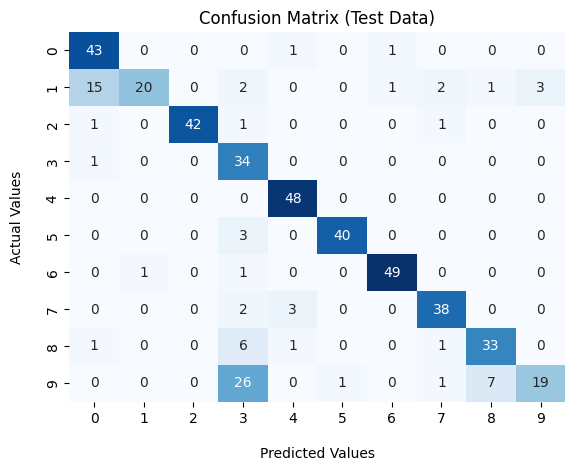

In [23]:
# load and split data
X, y = load_digits(n_class=10, return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)

# train model and make predictions
multi_perceptron = MultiClassPerceptron()
multi_perceptron.fit(X_train, y_train)
predicted = multi_perceptron.predict(X_test)

# plot confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, predicted), annot=True, cmap='Blues', fmt=".0f", cbar=False)
ax.set_title('Confusion Matrix (Test Data)')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values\n')
ax.xaxis.set_ticklabels(multi_perceptron.classes)
ax.yaxis.set_ticklabels(multi_perceptron.classes)

# print classification metrics
print(classification_report(y_test, predicted, target_names=list(map(str, multi_perceptron.classes.tolist()))))